<a href="https://colab.research.google.com/github/DanielleK2003/Finance/blob/main/Financial_ab_test_apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Apple stock data
data = yf.download("AAPL", start="2020-01-01", end="2025-01-01")

# Flatten MultiIndex columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Keep only Close column
data = data[['Close']].copy()

# Verify structure
print(data.head())
print(data.columns)

data.head()

/tmp/ipython-input-1372389255.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close
Date                 
2020-01-02  72.468269
2020-01-03  71.763710
2020-01-06  72.335548
2020-01-07  71.995361
2020-01-08  73.153496
Index(['Close'], dtype='object', name='Price')


Price,Close
Date,
2020-01-02,72.468269
2020-01-03,71.763710
2020-01-06,72.335548
2020-01-07,71.995361
2020-01-08,73.153496


In [11]:
# Strategy A: 50-day moving average
data['MA50'] = data['Close'].rolling(50).mean()

# Strategy B: 200-day moving average
data['MA200'] = data['Close'].rolling(200).mean()

# Signals
data['Signal_A'] = np.where(data['Close'] > data['MA50'], 1, 0)
data['Signal_B'] = np.where(data['Close'] > data['MA200'], 1, 0)

data.dropna(inplace=True)

data.head()

Price,Close,MA50,MA200,Signal_A,Signal_B
Date,,,,,
2020-10-15,117.303040,113.618952,85.882509,1,1
2020-10-16,115.660744,113.722397,86.098471,1,1
2020-10-19,112.706543,113.816999,86.303185,0,1
2020-10-20,114.193375,113.909950,86.512474,1,1
2020-10-21,113.571434,114.055619,86.720355,0,1


In [12]:
# Daily returns
data['Return'] = data['Close'].pct_change()

# Strategy returns (Calculate profit only when the strategy was active, using yesterday's signal)
data['Strategy_A_Return'] = data['Signal_A'].shift(1) * data['Return']
data['Strategy_B_Return'] = data['Signal_B'].shift(1) * data['Return']

data.dropna(inplace=True)

data.head()

Price,Close,MA50,MA200,Signal_A,Signal_B,Return,Strategy_A_Return,Strategy_B_Return
Date,,,,,,,,
2020-10-16,115.660744,113.722397,86.098471,1,1,-0.014000,-0.014000,-0.014000
2020-10-19,112.706543,113.816999,86.303185,0,1,-0.025542,-0.025542,-0.025542
2020-10-20,114.193375,113.909950,86.512474,1,1,0.013192,0.000000,0.013192
2020-10-21,113.571434,114.055619,86.720355,0,1,-0.005446,-0.005446,-0.005446
2020-10-22,112.483055,114.108872,86.917003,0,1,-0.009583,-0.000000,-0.009583


In [13]:
# Profitable days
success_A = (data['Strategy_A_Return'] > 0).sum()
success_B = (data['Strategy_B_Return'] > 0).sum()

# Total trades
total_A = (data['Signal_A'].shift(1) == 1).sum()
total_B = (data['Signal_B'].shift(1) == 1).sum()

print("Strategy A profitable days:", success_A)
print("Strategy B profitable days:", success_B)

print("Strategy A total trades:", total_A)
print("Strategy B total trades:", total_B)

Strategy A profitable days: 342
Strategy B profitable days: 438
Strategy A total trades: 644
Strategy B total trades: 829


In [14]:
from statsmodels.stats.proportion import proportions_ztest

successes = [success_A, success_B]
trials = [total_A, total_B]

stat, pval = proportions_ztest(successes, trials)

print("Z-statistic:", stat)
print("P-value:", pval)

if pval < 0.05:
    print("Statistically significant difference between strategies")
else:
    print("No statistically significant difference")

Z-statistic: 0.10330837939020784
P-value: 0.9177182254137344
No statistically significant difference


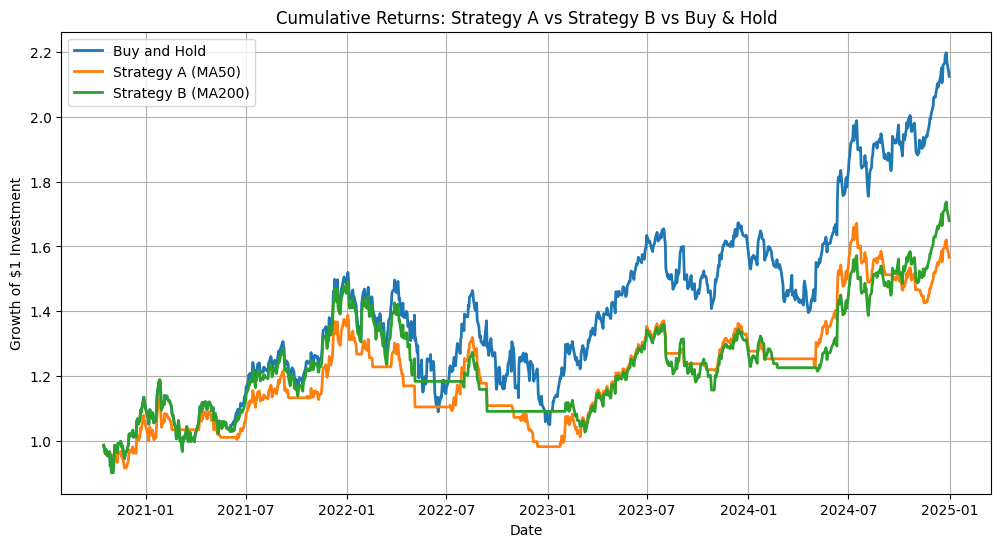

In [16]:
# Calculate cumulative returns to shows which strategy makes more money over time.
data['Cum_Return'] = (1 + data['Return']).cumprod() # Cumulative product
data['Cum_Strategy_A'] = (1 + data['Strategy_A_Return']).cumprod()
data['Cum_Strategy_B'] = (1 + data['Strategy_B_Return']).cumprod()

# Plot
plt.figure(figsize=(12,6))

plt.plot(data.index, data['Cum_Return'], label='Buy and Hold', linewidth=2)
plt.plot(data.index, data['Cum_Strategy_A'], label='Strategy A (MA50)', linewidth=2)
plt.plot(data.index, data['Cum_Strategy_B'], label='Strategy B (MA200)', linewidth=2)

plt.title("Cumulative Returns: Strategy A vs Strategy B vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid()

plt.show()

In [17]:
data.head()

Price,Close,MA50,MA200,Signal_A,Signal_B,Return,Strategy_A_Return,Strategy_B_Return,Cum_Return,Cum_Strategy_A,Cum_Strategy_B
Date,,,,,,,,,,,
2020-10-16,115.660744,113.722397,86.098471,1,1,-0.014000,-0.014000,-0.014000,0.986000,0.986000,0.986000
2020-10-19,112.706543,113.816999,86.303185,0,1,-0.025542,-0.025542,-0.025542,0.960815,0.960815,0.960815
2020-10-20,114.193375,113.909950,86.512474,1,1,0.013192,0.000000,0.013192,0.973490,0.960815,0.973490
2020-10-21,113.571434,114.055619,86.720355,0,1,-0.005446,-0.005446,-0.005446,0.968188,0.955582,0.968188
2020-10-22,112.483055,114.108872,86.917003,0,1,-0.009583,-0.000000,-0.009583,0.958910,0.955582,0.958910


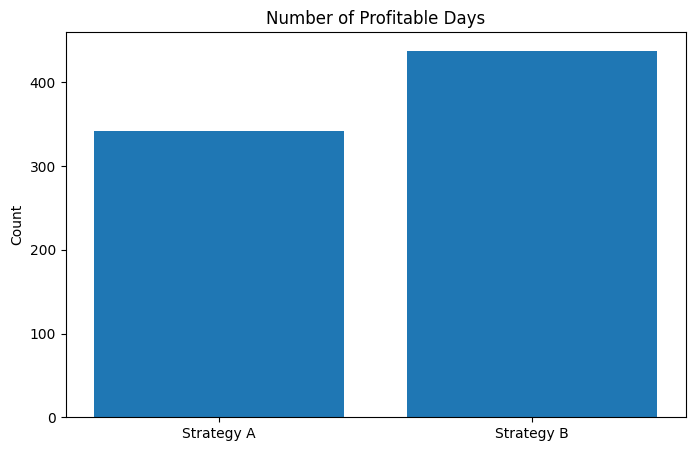

In [18]:
# Plot number of profitable days
profits = [
    (data['Strategy_A_Return'] > 0).sum(),
    (data['Strategy_B_Return'] > 0).sum()
]

labels = ['Strategy A', 'Strategy B']

plt.figure(figsize=(8,5))
plt.bar(labels, profits)

plt.title("Number of Profitable Days")
plt.ylabel("Count")
plt.show()

In [19]:
# Total returns
total_A = data['Cum_Strategy_A'].iloc[-1]
total_B = data['Cum_Strategy_B'].iloc[-1]

print("Final return Strategy A:", round(total_A, 2))
print("Final return Strategy B:", round(total_B, 2))

if total_A > total_B:
    print("Strategy A performs better overall.")
else:
    print("Strategy B performs better overall.")

Final return Strategy A: 1.57
Final return Strategy B: 1.68
Strategy B performs better overall.


**NB:** The AB test checks if the obseved difference is large enough or it is unlikely due to randomness.
The Z-statistic measures how big the difference is between the two strategies, in standardized units.

**Formula conceptually:** 𝑍 = difference observed / expected random variation

Large Z → big difference → likely real.

Small Z → small difference → likely random.

Z = value	Meaning

Z = 0	no difference

Z = 0.1	tiny difference

Z = 1	small difference

Z = 2	meaningful difference

Z = 3+	strong difference

The P-value tells you the probability that the observed difference happened randomly.

P-value	Meaning

Lower than 0.05	statistically significant (real difference)

Upper than 0.05	not statistically significant (likely random)

Final return Strategy A: 1.57

Final return Strategy B: 1.68

**CONCLUSION:** Strategy B performs better overall, but There is a P-value = 91.77% probability that this difference happened by chance.